In [41]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import matplotlib.pyplot as plt

# DOWNLOAD AND IMPORT dnn_app_utils-v2(i made some changes and renamed it as new_dnn) USED IN COURSERA
# Complete File is also present in the repository

from new_dnn import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
#this whole defination is copied as it from the coursera week4 assignment

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [43]:
train = pd.read_csv('dataset/train.csv')

In [44]:
#imputing with an approximate value gives better result than replacing null fields by median
#how to replacing null field by median of coloumn is shown later

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [45]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [46]:
# returns the number of null entries in the Age coloumn

train['Age'].isnull().sum()

0

In [47]:
# prune the titles from the names

def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

In [48]:
titles = sorted(set([x for x in train.Name.map(lambda x: get_title(x))]))
print('Different titles found on the dataset:')
print(len(titles), ':', titles)
print()

Different titles found on the dataset:
(17, ':', ['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess'])
()


In [49]:
# normalize the titles, returning 'Mr', 'Master', 'Miss' or 'Mrs'
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [50]:
# Lets create a new column for the titles
train['Title'] = train['Name'].map(lambda x: get_title(x))

# And replace the titles, so the are normalized to 'Mr', 'Miss' and 'Mrs'
train['Title'] = train.apply(replace_titles, axis=1)

# The name isn't helpful anymore, let's drop this column
train.drop('Name', axis=1, inplace=True)

In [51]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,S,Mr


In [52]:
# neural net is made to run on numbers so we have to converet textual entries to numbers

sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
title = pd.get_dummies(train['Title'],drop_first=True)

In [53]:
train.drop(['Sex','Embarked','Ticket', 'PassengerId', 'Title'],axis=1,inplace=True)
train = pd.concat([train,sex,embark,title],axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Miss,Mr,Mrs
0,0,3,22.0,1,0,7.2500,1,0,1,0,1,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,0,0,1,1,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1,0,1,0


In [61]:
#scaling the data makes the converging process faster for GD

from sklearn.preprocessing import StandardScaler
age = train['Age'].values.reshape(889,1)
scaler = StandardScaler()
scaler.fit(age)
scaled_age = scaler.transform(age)
train['Age'] = scaled_age

fare = train['Fare'].values.reshape(889,1)
scaler = StandardScaler()
scaler.fit(fare)
scaled_fare = scaler.transform(fare)
train['Fare'] = scaled_fare
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Miss,Mr,Mrs
0,0,3,-0.531670,1,0,-0.500240,1,0,1,0,1,0
1,1,1,0.680232,1,0,0.788947,0,0,0,0,0,1
2,1,3,-0.228695,0,0,-0.486650,0,0,1,1,0,0
3,1,1,0.453001,1,0,0.422861,0,0,1,0,0,1
4,0,3,0.453001,0,0,-0.484133,1,0,1,0,1,0


In [62]:
# split the train data into test/train sections

from sklearn.model_selection import train_test_split
X = train.drop('Survived', axis=1)
y = train['Survived']

# Create training and test splits
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

# Transpose data to fit neural network architecture
X_tr_T = X_tr.T
X_te_T = X_te.T
y_tr_T = y_tr.T.values.reshape(1,y_tr.shape[0])
y_te_T = y_te.T.values.reshape(1,y_te.shape[0])
X_tr_T.shape

(11, 711)

In [63]:
### CONSTANTS ###
# we will use a 7 layered neural net

layers_dims = [11, 25, 25, 25, 25, 25, 10, 1] #  7-layer model

Cost after iteration 0: 0.662203
Cost after iteration 100: 0.621340
Cost after iteration 200: 0.600079
Cost after iteration 300: 0.578251
Cost after iteration 400: 0.555628
Cost after iteration 500: 0.535177
Cost after iteration 600: 0.516850
Cost after iteration 700: 0.501511
Cost after iteration 800: 0.489200
Cost after iteration 900: 0.478947
Cost after iteration 1000: 0.469900
Cost after iteration 1100: 0.462530
Cost after iteration 1200: 0.456115
Cost after iteration 1300: 0.450217
Cost after iteration 1400: 0.445044
Cost after iteration 1500: 0.440196
Cost after iteration 1600: 0.435696
Cost after iteration 1700: 0.431378
Cost after iteration 1800: 0.427192
Cost after iteration 1900: 0.423210
Cost after iteration 2000: 0.419421
Cost after iteration 2100: 0.415853
Cost after iteration 2200: 0.412502
Cost after iteration 2300: 0.409457
Cost after iteration 2400: 0.406611


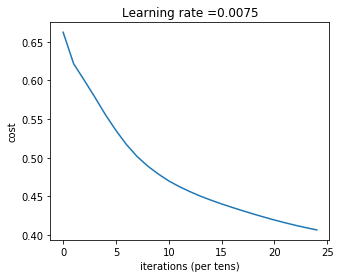

In [64]:
parameters = L_layer_model(X_tr_T, y_tr_T, layers_dims, num_iterations = 2500, print_cost = True)

In [65]:
#should give acc around 0.8 but is currently giving 0 
pred_train = predict(X_tr_T, y_tr_T, parameters)

Accuracy: 0


In [66]:
# same issue as previous
pred_test = predict(X_te_T, y_te_T, parameters)

Accuracy: 0


In [68]:
test = pd.read_csv('dataset/test.csv')

In [69]:
# make the test setsimilar to train set

test['Age'] = test[['Age','Pclass']].apply(impute_age,axis=1)
test.drop('Cabin',axis=1,inplace=True)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [70]:
titles = sorted(set([x for x in test.Name.map(lambda x: get_title(x))]))
print('Different titles found on the dataset:')
print(len(titles), ':', titles)
print()

Different titles found on the dataset:
(9, ':', ['Col', 'Dona', 'Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Ms', 'Rev'])
()


In [71]:
# Lets create a new column for the titles
test['Title'] = test['Name'].map(lambda x: get_title(x))

# And replace the titles, so the are normalized to 'Mr', 'Miss' and 'Mrs'
test['Title'] = test.apply(replace_titles, axis=1)
test.drop('Name', axis=1, inplace=True)
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,male,27.0,0,0,315154,8.6625,S,Mr
4,896,3,female,22.0,1,1,3101298,12.2875,S,Mrs


In [72]:
sex = pd.get_dummies(test['Sex'],drop_first=True)
embark = pd.get_dummies(test['Embarked'],drop_first=True)
title = pd.get_dummies(test['Title'],drop_first=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


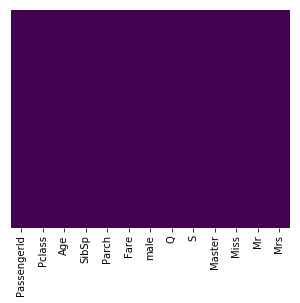

In [82]:
test.drop(['Sex','Embarked','Ticket', 'Title'],axis=1,inplace=True)
test = pd.concat([test,sex,embark,title],axis=1)
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [75]:
test['Fare'].isnull().sum()

0

In [74]:
# replace null entries in Fare coloumn with the median of that coloumn
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [76]:
#scale the test data
from sklearn.preprocessing import StandardScaler
age = test['Age'].values.reshape(418,1)
scaler = StandardScaler()
scaler.fit(age)
scaled_age = scaler.transform(age)
test['Age'] = scaled_age

fare = test['Fare'].values.reshape(418,1)
scaler = StandardScaler()
scaler.fit(fare)
scaled_fare = scaler.transform(fare)
test['Fare'] = scaled_fare

In [83]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Master,Miss,Mr,Mrs
0,892,3,0.401768,0,0,-0.497413,1,1,0,0,0,1,0
1,893,3,1.371615,1,0,-0.512278,0,0,1,0,0,0,1
2,894,2,2.535433,0,0,-0.464100,1,1,0,0,0,1,0
3,895,3,-0.180141,0,0,-0.482475,1,0,1,0,0,1,0
4,896,3,-0.568080,1,1,-0.417492,0,0,1,0,0,0,1


In [85]:
X = test.drop(['PassengerId', 'Master'], axis=1)

In [87]:
X_tr_T = X.T
X_tr_T.shape

(11, 418)

In [88]:
#run the test data through the neural net

probas, caches = L_model_forward(X_tr_T, parameters)

In [89]:
p = np.zeros((1,X_tr_T.shape[1]))
for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

In [90]:
pIds = pd.DataFrame(data=test['PassengerId'], columns=['PassengerId'], dtype=int)

# Transpose the predictions data frame into a column vector
preds = pd.DataFrame(data=p.T, columns=['Survived'], dtype=int)

final_prediction = pd.concat([pIds, preds], axis=1)

In [91]:
final_prediction.to_csv('final_submission.csv', index=False)
#gives 0.77 accuracy on submission to kaggle